### Changelog

|| Version | Comments | LB |
|---|  --- | --- | --- |
|**Best**|8| Vanilla Unet w/ 256x256, 40 epoch, no aug, no lr sch, no pre/post processing, L2 norm | `0.04` |

In [1]:
# !pip3 install -q tifffile

You are using pip version 10.0.1, however version 22.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Import, SEED, Config:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import json
import gc
import time
from tqdm import tqdm
import random
from collections import defaultdict
from IPython.display import display

#Pytorch Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler
from tifffile import imread

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.model_selection import train_test_split

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings("ignore")
# pd.set_option('display.max_colwidth', 100)

/home/lakshita/somusan/hubmap_kaggle/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters etc.
# Hyperparameters
CONFIG = {
    "in_channels" :3,
    "num_classes": 1,
    "BATCH_SIZE" : 8,
    "NUM_EPOCHS" : 40,
    "n_accumulate": 1,
    "competition": "HuBMAP-Kaggle", # HuBMAP-Kaggle
    "model_name": "Vanilla_Unet",
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", 
    "AUG": "No",
    "SEED": 42,
    "opt": 'Adam',
    "Normalization": "L2",
    "img_size": 256
}

In [3]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CONFIG["SEED"])

> SEEDING DONE


# WandB:

In [4]:
import wandb

wandb.login()

run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['semantic segmentation', CONFIG['model_name']],
                 anonymous='must',
                 name = "Vanilla_Unet_1",
                 notes = "")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: somusan. Use `wandb login --relogin` to force relogin


## Tabular:

In [8]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/"
train_df = pd.read_csv(os.path.join(DIR,"train.csv"))
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 14836...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 34 730692 35 733679 54 736677 58 739676 65 742675 6...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 1240619 61 1243618 63 1246618 63 1249610 82 1252609 ...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 3458491 43 3461488 46 3464486 48 3467485 49 3470484 ...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 490854 169 493845 182 496836 194 499827 205 502820 216...,21.0,Female


In [9]:
TRAIN_DIR = DIR + "train_images/"
func = lambda x: TRAIN_DIR + str(x) + ".tiff"
train_df["img_path"] = train_df["id"].apply(func)
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,img_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 14836...,37.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 34 730692 35 733679 54 736677 58 739676 65 742675 6...,76.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 1240619 61 1243618 63 1246618 63 1249610 82 1252609 ...,82.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 3458491 43 3461488 46 3464486 48 3467485 49 3470484 ...,78.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 490854 169 493845 182 496836 194 499827 205 502820 216...,21.0,Female,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10610.tiff


In [12]:
MASK_DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/"
func1 = lambda x: MASK_DIR + str(x) + ".npy"
train_df["mask_path"] = train_df["id"].apply(func1)
print(train_df["mask_path"].iloc[9])
train_df.head()

/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10892.npy


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,img_path,mask_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 14836...,37.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10044.tiff,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10044.npy
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 34 730692 35 733679 54 736677 58 739676 65 742675 6...,76.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10274.tiff,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10274.npy
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 1240619 61 1243618 63 1246618 63 1249610 82 1252609 ...,82.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10392.tiff,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10392.npy
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 3458491 43 3461488 46 3464486 48 3467485 49 3470484 ...,78.0,Male,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10488.tiff,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10488.npy
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 490854 169 493845 182 496836 194 499827 205 502820 216...,21.0,Female,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/10610.tiff,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10610.npy


In [13]:
train_df["mask_path"]

0      /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10044.npy
1      /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10274.npy
2      /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10392.npy
3      /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10488.npy
4      /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/10610.npy
                                         ...                                    
346     /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/9517.npy
347     /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/9769.npy
348     /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/9777.npy
349     /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/9791.npy
350     /home/lakshita/somusan/hubmap_kaggle/hubmap_data/train_masks_np/9904.npy
Name: mask_path, Length: 351, dtype: object

In [15]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.__len__(), len(test_df)

(224, 56)

In [10]:
%timeit img_temp = imread(train_df["img_path"].iloc[0])

4.57 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Pytorch Data Class:

In [17]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])


def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))



class hubmap_data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img_paths = df["img_path"].to_numpy()
        self.mask_paths = df["mask_path"].to_numpy()
        self.transform = transform
        
        
    def __getitem__(self, index):
        # load data from the pre-processed npy files
        img_file = self.img_paths[index]
#         print(img_file)
        mask_file = self.mask_paths[index]
        img = imread(img_file)#cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
#         img = imread(img_file) #np.moveaxis(imread(img_file), -1, 0) #torch.from_numpy(np.moveaxis(imread(img_file), -1, 0))
        # semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
#         mask = torch.from_numpy(np.moveaxis(np.load(mask_file), -1, 0))
        mask = np.load(mask_file)#np.moveaxis(np.load(mask_file), -1, 0) #torch.from_numpy(np.moveaxis(np.load(mask_file), -1, 0))
        
        
#       print(depth.shape)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

            if mask.shape[-1] == 1:
                mask = mask.permute(2,0,1)
                
                
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)

    def __len__(self):
        return len(self.df)

In [18]:
train_transform = A.Compose(
    [
        A.Resize(256, 256, p=1),
#         A.HorizontalFlip(p=1.0),
#         A.RandomCrop(224, 224, p=0.3),
#         A.RandomSizedCrop(cfg["min_max_height"], cfg["height"], cfg["width"], cfg["w2h_ratio"], cfg["interpolation"], p=1), 
#         ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(256, 256, p=1.0),
#         ToTensorV2(),
    ]
)

In [19]:
train_data = hubmap_data(train_df,train_transform)
test_data = hubmap_data(test_df, test_transform)

print(train_data[10][0].shape, train_data[10][1].shape)
# test_data[10][0].shape, test_data[10][1].shape

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


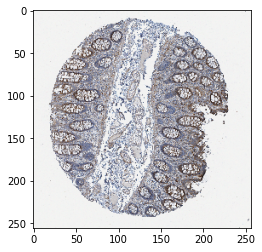

In [20]:
temp_img = train_data[10][0]
temp_mask = train_data[10][1]
# plt.imshow(temp_mask.detach().numpy())
# plt.imshow(temp_img.permute(1,2,0).detach().numpy())
img_trfm = ((temp_img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
plt.imshow(img_trfm)
# temp_img.permute(1,2,0).detach().numpy()

# Unet Model:

In [21]:
def init_model():
    model =  smp.Unet(
                 encoder_name='efficientnet-b0',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)
    return model

# Model check:

In [22]:
train_on_gpu = torch.cuda.is_available()
model = init_model() #UNet(n_channels=CONFIG["in_channels"], n_classes=CONFIG["num_classes"])
if train_on_gpu:
    model.cuda()

model(temp_img.unsqueeze(0).float().cuda()).shape

torch.Size([1, 1, 256, 256])

# DataLoader

In [23]:
# REMARK shuffle = False [result might change with shuffle =True]
train_loader = torch.utils.data.DataLoader(
               dataset=train_data,
               batch_size=CONFIG["BATCH_SIZE"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_data,
              batch_size=CONFIG["BATCH_SIZE"],
              shuffle=False,
              num_workers=2)

In [ ]:
# ds = HuBMAPDataset(tfms=albu_aug())
# dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
it = iter(train_loader)
imgs,masks = next(it)
print(masks.dtype)
plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0))).numpy().astype(np.uint8)  # H , W , C
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
# del ds,dl,imgs,masks

# Loss, Optimizer & Metric:

In [25]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

loss_fn = DiceLoss() #Dice()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["LEARNING_RATE"],weight_decay=1e-5)

In [26]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

# model save class:

In [27]:
model_path = "./model_weights"
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
def save_model(model, optimizer, criterion, epoch):
    """
    Function to save the trained model to disk.
    """
    print(f"\n Saving model at {epoch}th epoch")
    fname = f'{model_path}/{CONFIG["model_name"]}-{CONFIG["LEARNING_RATE"]}-{CONFIG["AUG"]}-{epoch}-{CONFIG["BATCH_SIZE"]}.pth'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, fname )
    return fname

## Train & Validation Function:

In [30]:
def train_fn(loader, model, optimizer, loss_fn,epoch):
    bar = tqdm(enumerate(loader), total=len(loader))
    
    
    running_loss = 0.0
    dataset_size = 0
    
    for batch_idx, (data, targets) in bar:
        data = data.to(device=CONFIG["DEVICE"])
        targets = targets.float().to(device=CONFIG["DEVICE"])

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(loader)
#         running_loss += (loss.item() * BATCH_SIZE)
#         dataset_size += BATCH_SIZE
        
#         epoch_loss = running_loss / dataset_size
        # update tqdm loop
        bar.set_postfix(Epoch=epoch,loss=epoch_loss)
    
        
    gc.collect()
    
    return epoch_loss

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
#     criterion = losses[CFG.loss]
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, masks) in pbar:
        images  = images.to(CONFIG["DEVICE"], dtype=torch.float)
        masks   = masks.to(CONFIG["DEVICE"], dtype=torch.float)
        
        
        y_pred  = model(images)
        loss    = loss_fn(y_pred, masks)
        
        running_loss += (loss.item() * CONFIG["BATCH_SIZE"])
        dataset_size += CONFIG["BATCH_SIZE"]
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# Train loop:

===================== Epoch: [1/40] =====================


100%|██████████| 7/7 [00:44<00:00,  6.35s/it, gpu_memory=3.50 GB, lr=0.00010, valid_loss=0.8255]



 Saving model at 1th epoch

 Final Train Loss: 0.8132  |  Final Val Loss: 0.8255
Valid Dice: 0.1624 | Valid Jaccard: 0.0948
val dice increased: -inf ---> 0.16235117614269257
val jaccard increased: -inf ---> 0.0947938784956932
===================== Epoch: [2/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.91it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8124]



 Saving model at 2th epoch

 Final Train Loss: 0.8031  |  Final Val Loss: 0.8124
Valid Dice: 0.1624 | Valid Jaccard: 0.0948
===================== Epoch: [3/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8102]



 Saving model at 3th epoch

 Final Train Loss: 0.7994  |  Final Val Loss: 0.8102
Valid Dice: 0.2212 | Valid Jaccard: 0.1374
val dice increased: 0.16235117614269257 ---> 0.22124025225639343
val jaccard increased: 0.0947938784956932 ---> 0.13735531270503998
===================== Epoch: [4/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.99it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8069]



 Saving model at 4th epoch

 Final Train Loss: 0.7973  |  Final Val Loss: 0.8069
Valid Dice: 0.2372 | Valid Jaccard: 0.1496
val dice increased: 0.22124025225639343 ---> 0.23722092807292938
val jaccard increased: 0.13735531270503998 ---> 0.14961457252502441
===================== Epoch: [5/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8059]



 Saving model at 5th epoch

 Final Train Loss: 0.7960  |  Final Val Loss: 0.8059
Valid Dice: 0.2449 | Valid Jaccard: 0.1554
val dice increased: 0.23722092807292938 ---> 0.2449216991662979
val jaccard increased: 0.14961457252502441 ---> 0.1554485261440277
===================== Epoch: [6/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.93it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8057]



 Saving model at 6th epoch

 Final Train Loss: 0.7944  |  Final Val Loss: 0.8057
Valid Dice: 0.2552 | Valid Jaccard: 0.1638
val dice increased: 0.2449216991662979 ---> 0.2552242875099182
val jaccard increased: 0.1554485261440277 ---> 0.1637946516275406
===================== Epoch: [7/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.00it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8047]



 Saving model at 7th epoch

 Final Train Loss: 0.7929  |  Final Val Loss: 0.8047
Valid Dice: 0.2506 | Valid Jaccard: 0.1601
===================== Epoch: [8/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.15it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8027]



 Saving model at 8th epoch

 Final Train Loss: 0.7921  |  Final Val Loss: 0.8027
Valid Dice: 0.2872 | Valid Jaccard: 0.1887
val dice increased: 0.2552242875099182 ---> 0.2871531844139099
val jaccard increased: 0.1637946516275406 ---> 0.18868796527385712
===================== Epoch: [9/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.83it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8016]



 Saving model at 9th epoch

 Final Train Loss: 0.7912  |  Final Val Loss: 0.8016
Valid Dice: 0.2819 | Valid Jaccard: 0.1842
===================== Epoch: [10/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8024]



 Saving model at 10th epoch

 Final Train Loss: 0.7913  |  Final Val Loss: 0.8024
Valid Dice: 0.2988 | Valid Jaccard: 0.1979
val dice increased: 0.2871531844139099 ---> 0.29884931445121765
val jaccard increased: 0.18868796527385712 ---> 0.19786182045936584
===================== Epoch: [11/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.17it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8040]



 Saving model at 11th epoch

 Final Train Loss: 0.7908  |  Final Val Loss: 0.8040
Valid Dice: 0.3198 | Valid Jaccard: 0.2132
val dice increased: 0.29884931445121765 ---> 0.3198131024837494
val jaccard increased: 0.19786182045936584 ---> 0.21321061253547668
===================== Epoch: [12/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.02it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8062]



 Saving model at 12th epoch

 Final Train Loss: 0.7900  |  Final Val Loss: 0.8062
Valid Dice: 0.3257 | Valid Jaccard: 0.2187
val dice increased: 0.3198131024837494 ---> 0.32569172978401184
val jaccard increased: 0.21321061253547668 ---> 0.21871468424797058
===================== Epoch: [13/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.15it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8021]



 Saving model at 13th epoch

 Final Train Loss: 0.7946  |  Final Val Loss: 0.8021
Valid Dice: 0.2848 | Valid Jaccard: 0.1873
===================== Epoch: [14/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.12it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8016]



 Saving model at 14th epoch

 Final Train Loss: 0.7898  |  Final Val Loss: 0.8016
Valid Dice: 0.3283 | Valid Jaccard: 0.2206
val dice increased: 0.32569172978401184 ---> 0.32833418250083923
val jaccard increased: 0.21871468424797058 ---> 0.2206171602010727
===================== Epoch: [15/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.91it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8028]



 Saving model at 15th epoch

 Final Train Loss: 0.7891  |  Final Val Loss: 0.8028
Valid Dice: 0.3360 | Valid Jaccard: 0.2268
val dice increased: 0.32833418250083923 ---> 0.33599191904067993
val jaccard increased: 0.2206171602010727 ---> 0.2267662137746811
===================== Epoch: [16/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.78it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7996]



 Saving model at 16th epoch

 Final Train Loss: 0.7888  |  Final Val Loss: 0.7996
Valid Dice: 0.3288 | Valid Jaccard: 0.2203
===================== Epoch: [17/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8022]



 Saving model at 17th epoch

 Final Train Loss: 0.7871  |  Final Val Loss: 0.8022
Valid Dice: 0.3392 | Valid Jaccard: 0.2283
val dice increased: 0.33599191904067993 ---> 0.33915552496910095
val jaccard increased: 0.2267662137746811 ---> 0.2283368855714798
===================== Epoch: [18/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.04it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7994]



 Saving model at 18th epoch

 Final Train Loss: 0.7879  |  Final Val Loss: 0.7994
Valid Dice: 0.3587 | Valid Jaccard: 0.2439
val dice increased: 0.33915552496910095 ---> 0.3587295114994049
val jaccard increased: 0.2283368855714798 ---> 0.24394503235816956
===================== Epoch: [19/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.28it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7996]



 Saving model at 19th epoch

 Final Train Loss: 0.7878  |  Final Val Loss: 0.7996
Valid Dice: 0.3474 | Valid Jaccard: 0.2357
===================== Epoch: [20/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.81it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7999]



 Saving model at 20th epoch

 Final Train Loss: 0.7866  |  Final Val Loss: 0.7999
Valid Dice: 0.3524 | Valid Jaccard: 0.2390
===================== Epoch: [21/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.14it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7997]



 Saving model at 21th epoch

 Final Train Loss: 0.7855  |  Final Val Loss: 0.7997
Valid Dice: 0.3608 | Valid Jaccard: 0.2443
val dice increased: 0.3587295114994049 ---> 0.36084941029548645
val jaccard increased: 0.24394503235816956 ---> 0.24428865313529968
===================== Epoch: [22/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.01it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.8012]



 Saving model at 22th epoch

 Final Train Loss: 0.7859  |  Final Val Loss: 0.8012
Valid Dice: 0.3646 | Valid Jaccard: 0.2493
val dice increased: 0.36084941029548645 ---> 0.3645763397216797
val jaccard increased: 0.24428865313529968 ---> 0.2492571920156479
===================== Epoch: [23/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.99it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7982]



 Saving model at 23th epoch

 Final Train Loss: 0.7857  |  Final Val Loss: 0.7982
Valid Dice: 0.3512 | Valid Jaccard: 0.2377
===================== Epoch: [24/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.13it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7985]



 Saving model at 24th epoch

 Final Train Loss: 0.7863  |  Final Val Loss: 0.7985
Valid Dice: 0.3607 | Valid Jaccard: 0.2448
===================== Epoch: [25/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.83it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7982]



 Saving model at 25th epoch

 Final Train Loss: 0.7855  |  Final Val Loss: 0.7982
Valid Dice: 0.3591 | Valid Jaccard: 0.2439
===================== Epoch: [26/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7975]



 Saving model at 26th epoch

 Final Train Loss: 0.7849  |  Final Val Loss: 0.7975
Valid Dice: 0.3465 | Valid Jaccard: 0.2329
===================== Epoch: [27/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.95it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7971]



 Saving model at 27th epoch

 Final Train Loss: 0.7835  |  Final Val Loss: 0.7971
Valid Dice: 0.3661 | Valid Jaccard: 0.2487
val dice increased: 0.3645763397216797 ---> 0.36611494421958923
===================== Epoch: [28/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.89it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7971]



 Saving model at 28th epoch

 Final Train Loss: 0.7831  |  Final Val Loss: 0.7971
Valid Dice: 0.3647 | Valid Jaccard: 0.2479
===================== Epoch: [29/40] =====================


100%|██████████| 7/7 [00:01<00:00,  6.59it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7989]



 Saving model at 29th epoch

 Final Train Loss: 0.7832  |  Final Val Loss: 0.7989
Valid Dice: 0.3609 | Valid Jaccard: 0.2440
===================== Epoch: [30/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7972]



 Saving model at 30th epoch

 Final Train Loss: 0.7834  |  Final Val Loss: 0.7972
Valid Dice: 0.3920 | Valid Jaccard: 0.2720
val dice increased: 0.36611494421958923 ---> 0.3920097351074219
val jaccard increased: 0.2492571920156479 ---> 0.27202779054641724
===================== Epoch: [31/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.22it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7972]



 Saving model at 31th epoch

 Final Train Loss: 0.7821  |  Final Val Loss: 0.7972
Valid Dice: 0.3544 | Valid Jaccard: 0.2385
===================== Epoch: [32/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.18it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7974]



 Saving model at 32th epoch

 Final Train Loss: 0.7810  |  Final Val Loss: 0.7974
Valid Dice: 0.3756 | Valid Jaccard: 0.2556
===================== Epoch: [33/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.14it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7976]



 Saving model at 33th epoch

 Final Train Loss: 0.7809  |  Final Val Loss: 0.7976
Valid Dice: 0.3944 | Valid Jaccard: 0.2732
val dice increased: 0.3920097351074219 ---> 0.394437313079834
val jaccard increased: 0.27202779054641724 ---> 0.27320823073387146
===================== Epoch: [34/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7963]



 Saving model at 34th epoch

 Final Train Loss: 0.7810  |  Final Val Loss: 0.7963
Valid Dice: 0.3591 | Valid Jaccard: 0.2437
===================== Epoch: [35/40] =====================


100%|██████████| 7/7 [00:01<00:00,  7.00it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7963]



 Saving model at 35th epoch

 Final Train Loss: 0.7798  |  Final Val Loss: 0.7963
Valid Dice: 0.3572 | Valid Jaccard: 0.2422
===================== Epoch: [36/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.02it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7953]



 Saving model at 36th epoch

 Final Train Loss: 0.7797  |  Final Val Loss: 0.7953
Valid Dice: 0.3785 | Valid Jaccard: 0.2591
===================== Epoch: [37/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.00it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7956]



 Saving model at 37th epoch

 Final Train Loss: 0.7788  |  Final Val Loss: 0.7956
Valid Dice: 0.3809 | Valid Jaccard: 0.2620
===================== Epoch: [38/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.32it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7956]



 Saving model at 38th epoch

 Final Train Loss: 0.7789  |  Final Val Loss: 0.7956
Valid Dice: 0.3667 | Valid Jaccard: 0.2493
===================== Epoch: [39/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.22it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7960]



 Saving model at 39th epoch

 Final Train Loss: 0.7788  |  Final Val Loss: 0.7960
Valid Dice: 0.3569 | Valid Jaccard: 0.2410
===================== Epoch: [40/40] =====================


100%|██████████| 7/7 [00:00<00:00,  7.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.7955]



 Saving model at 40th epoch

 Final Train Loss: 0.7781  |  Final Val Loss: 0.7955
Valid Dice: 0.3567 | Valid Jaccard: 0.2406

 ====================== [Training Summary] ====================== 

Training complete in 0h 10m 17s
avg time per [train + val] epoch 0h 0m 15s
Best: ~~~~~~ dice: 0.3944  || jaccard 0.2732 || val_loss 0.7953 || train_loss 0.7781 ~~~~~~
Saved training summary...




,epoch,Train_Loss,Valid_Loss,Valid_jaccard,Valid_dice,model_file
0,1,0.813244,0.825458,0.094794,0.162351,./model_weights/Vanilla_Unet-0.0001-No-1-8.pth
1,2,0.803067,0.812416,0.094794,0.162351,./model_weights/Vanilla_Unet-0.0001-No-2-8.pth
2,3,0.799428,0.810205,0.137355,0.221240,./model_weights/Vanilla_Unet-0.0001-No-3-8.pth
3,4,0.797331,0.806945,0.149615,0.237221,./model_weights/Vanilla_Unet-0.0001-No-4-8.pth
4,5,0.796013,0.805911,0.155449,0.244922,./model_weights/Vanilla_Unet-0.0001-No-5-8.pth
5,6,0.794384,0.805677,0.163795,0.255224,./model_weights/Vanilla_Unet-0.0001-No-6-8.pth
6,7,0.792853,0.804670,0.160081,0.250584,./model_weights/Vanilla_Unet-0.0001-No-7-8.pth
7,8,0.792080,0.802681,0.188688,0.287153,./model_weights/Vanilla_Unet-0.0001-No-8-8.pth
8,9,0.791235,0.801557,0.184180,0.281867,./model_weights/Vanilla_Unet-0.0001-No-9-8.pth
9,10,0.791341,0.802432,0.197862,0.298849,./model_weights/Vanilla_Unet-0.0001-No-10-8.pth


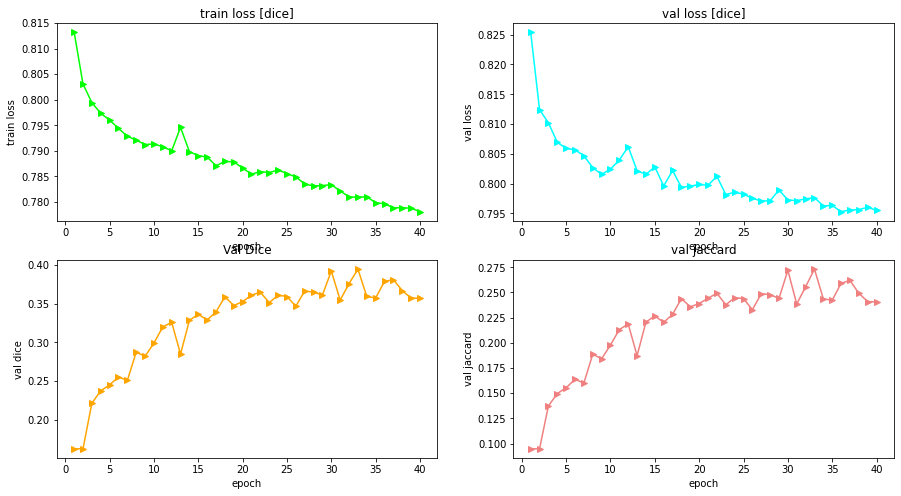

In [32]:
history = defaultdict(list)
best_val_dice = -float('inf')
best_val_jaccard = -float('inf')
start = time.time()


for epoch in range(CONFIG["NUM_EPOCHS"]):
    
    print(f'{sr_}===================== Epoch: [{epoch+1}/{CONFIG["NUM_EPOCHS"]}] =====================')

    # train and validation loop
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch+1)
    val_loss, val_scores = valid_one_epoch(model, test_loader,CONFIG["DEVICE"], epoch+1)
    val_dice, val_jaccard = val_scores
    
    
    # save model
    model_file = save_model(model, optimizer, loss_fn, epoch+1)
    
    
    # weight and baise Log the metrics
    wandb.log({"Train Loss": train_loss})
    wandb.log({"Valid Loss": val_loss})
    wandb.log({"Valid dice": val_dice})
    wandb.log({"Valid jaccard": val_jaccard})

    # logging
    history["epoch"].append(epoch+1)
    history['Train_Loss'].append(train_loss)
    history['Valid_Loss'].append(val_loss)
    history['Valid_jaccard'].append(val_jaccard)
    history['Valid_dice'].append(val_dice)
    history["model_file"].append(model_file)

    
    # print loss and scores
    print(f"\n Final Train Loss: {train_loss:0.4f}  |  Final Val Loss: {val_loss:0.4f}") 
    
    print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    
    # print best val score
    if best_val_dice < val_dice:
        print(f"{b_}val dice increased: {best_val_dice} ---> {val_dice}")
        best_val_dice = val_dice
    
    if best_val_jaccard < val_jaccard:
        print(f"{b_}val jaccard increased: {best_val_jaccard} ---> {val_jaccard}")
        best_val_jaccard = val_jaccard

        
        
# print time
end = time.time()
time_elapsed = end - start
avg_time_per_epoch = time_elapsed/CONFIG["NUM_EPOCHS"] 
summary_df = pd.DataFrame.from_dict(history)

print(f'\n ====================== [Training Summary] ====================== \n')
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

print('avg time per [train + val] epoch {:.0f}h {:.0f}m {:.0f}s'.format(
    avg_time_per_epoch // 3600, (avg_time_per_epoch % 3600) // 60, (avg_time_per_epoch % 3600) % 60))

print("Best: ~~~~~~ dice: {:.4f}  || jaccard {:.4f} || val_loss {:.4f} || train_loss {:.4f} ~~~~~~".format(
    best_val_dice, best_val_jaccard, min(history['Valid_Loss']), min(history['Train_Loss'])))


summary_df.to_csv('training_summary.csv')
print("Saved training summary...")

print(f'\n =============================================================== \n')

display(summary_df)

# plotting training and validation loss
plt.figure(figsize=(15,8))

fig1 = plt.subplot(2,2,1)
fig1.plot(history['epoch'], history['Train_Loss'], color='lime', marker='>')
fig1.set_title("train loss [dice]")
fig1.set(xlabel='epoch', ylabel='train loss')

fig2 = plt.subplot(2,2,2)
fig2.plot(history['epoch'], history['Valid_Loss'], color='cyan',  marker='>')
fig2.set_title("val loss [dice]")
fig2.set(xlabel='epoch', ylabel='val loss')

fig3 = plt.subplot(2,2,3)
fig3.plot(history['epoch'], history['Valid_dice'], color='orange',  marker='>')
fig3.set_title("Val Dice")
fig3.set(xlabel='epoch', ylabel='val dice')

fig4 = plt.subplot(2,2,4)
fig4.plot(history['epoch'], history['Valid_jaccard'], color='lightcoral',  marker='>')
fig4.set_title("val jaccard")
fig4.set(xlabel='epoch', ylabel='val jaccard')

plt.show();

In [ ]:
import gc
a = gc.collect()

# Model File Check:

In [24]:
!ls -la ./model_weights

total 6937288
drwxr-xr-x 2 root root      4096 Jul 24 09:57 .
drwxr-xr-x 4 root root      4096 Jul 24 09:57 ..
-rw-r--r-- 1 root root 177593833 Jul 24 09:04 Vanilla_Unet-0.0001-No-1-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:16 Vanilla_Unet-0.0001-No-10-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:17 Vanilla_Unet-0.0001-No-11-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:18 Vanilla_Unet-0.0001-No-12-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:20 Vanilla_Unet-0.0001-No-13-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:21 Vanilla_Unet-0.0001-No-14-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:22 Vanilla_Unet-0.0001-No-15-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:24 Vanilla_Unet-0.0001-No-16-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:25 Vanilla_Unet-0.0001-No-17-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:26 Vanilla_Unet-0.0001-No-18-8.pth
-rw-r--r-- 1 root root 177593897 Jul 24 09:28 Vanilla_Unet-0.0001-No-19-8.pth
-rw-r--r-- 1 root root 177593833